In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras import backend as K

In [2]:
#X_train=np.loadtxt('../../training_data/Xtrain_seg_mask_rv_3.csv',delimiter=',')
#Y_train=np.loadtxt('../../training_data/Ytrain_seg_mask_rv_3.csv',delimiter=',')

#print(X_train.shape,Y_train.shape)

In [2]:

def _parse_tfr_element(element):
  desc = {
        'input':tf.io.FixedLenFeature([], tf.string),
        'map':tf.io.FixedLenFeature([], tf.string),
        'counts': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),  
    }
  example_message = tf.io.parse_single_example(element, desc)

  #return(example_message['counts'])
  binp = example_message['input'] # get byte 
  bmap = example_message['map'] # get byte string
  bcts = example_message['counts'] # get byte string
  bid = example_message['id'] # get byte string
  print(binp.shape,bmap.shape,bcts.shape)
  inp = tf.io.parse_tensor(binp, out_type=tf.float32) # restore 2D array from byte string
  map = tf.io.parse_tensor(bmap, out_type=tf.bool)
  cts = tf.io.parse_tensor(bcts, out_type=tf.int8)
  id = tf.io.parse_tensor(bid, out_type=tf.string)
  return (inp,map,cts,id)


tfr_dataset = tf.data.TFRecordDataset(['../../training_data/seg_mask_training_av_aug']) 
tfr_testdata = tf.data.TFRecordDataset(['../../training_data/seg_mask_test_av_aug']) 
#for serialized_instance in tfr_dataset:
#  print(serialized_instance) # print serialized example messages
#zprint(len(tfr_dataset))
dataset = tfr_dataset.map(_parse_tfr_element)
testdata = tfr_testdata.map(_parse_tfr_element)

Xtrain=[]
Ytrain=[]

for instance in dataset:
  Xtrain.append(instance[0])
  Ytrain.append(instance[1])

Xtest=[]
Ytest=[]

for instance in testdata:
  Xtest.append(instance[0])
  Ytest.append(instance[1])

() () ()
() () ()


In [3]:
TestID=[]
for instance in testdata:
  TestID.append(instance[3])

In [4]:
Ytrain=np.asarray(Ytrain).reshape(len(Xtrain),4000,3)
Ytest=np.asarray(Ytest).reshape(len(Xtest),4000,3)
print(Ytrain.shape, Ytest.shape)

(8367, 4000, 3) (2092, 4000, 3)


In [5]:
kernel_size = 8
kernel = np.ones(kernel_size) / kernel_size
Xtrain = np.array([np.convolve(Xtrain[i], kernel, mode='same') for i in range(len(Xtrain))])
Xtrain=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])

Xtest = np.array([np.convolve(Xtest[i], kernel, mode='same') for i in range(len(Xtest))])
Xtest=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])


In [6]:
#Xtrain, Xtest, Ytrain, Ytest= train_test_split(X_train, Y_train, test_size=0.2)
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(8367, 4000) (8367, 4000, 3) (2092, 4000) (2092, 4000, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

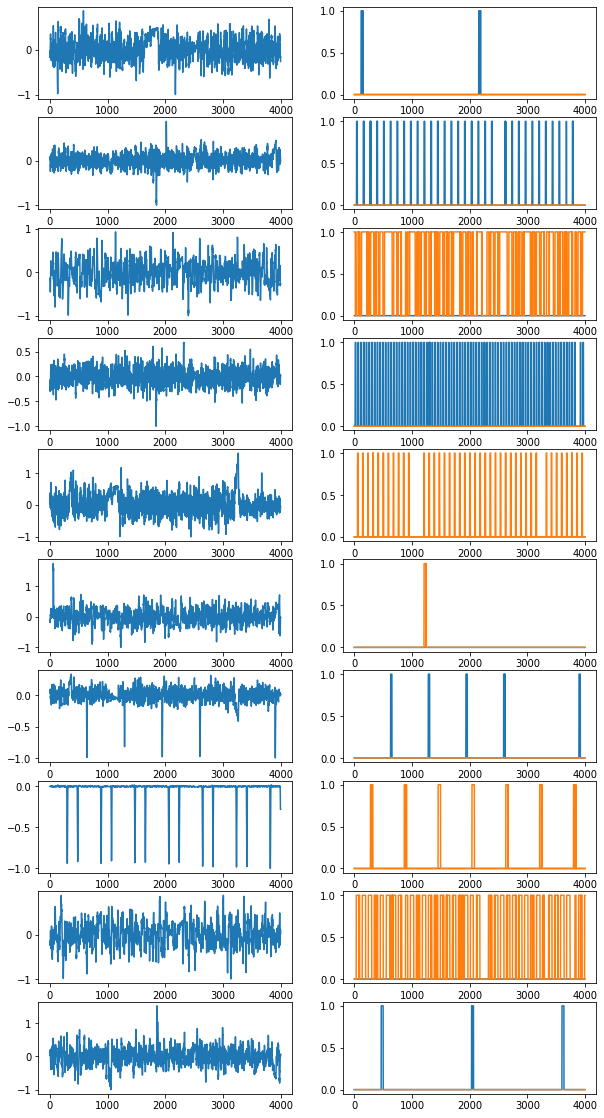

In [7]:
Ytrain = np.asarray(Ytrain, dtype = 'float32')
Ytest = np.asarray(Ytest, dtype = 'float32')
vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,2,figsize=(10,20))
for i in range(0,10):
    ax[i][0].plot(Xtrain[vararr[i]])
    #ax[i][1].plot(Ytrain[vararr[i],:,2])
    ax[i][1].plot(Ytrain[vararr[i],:,0])
    ax[i][1].plot(Ytrain[vararr[i],:,1])
    #ax[i][1].set_xlim(2600,3000)
plt.show

In [8]:

def dice_coeff(y_true, y_pred):
    smooth = 0.00001
    #sh = tf.shape(y_true)
    #y_true_int = tf.reshape(y_true, [sh[0], sh[1]*sh[2]])
    #y_pred_int = tf.reshape(y_pred, [sh[0], sh[1]*sh[2]])
    #w = 1 - tf.reduce_sum(y_true,(1,2)) / 9600.
    #w = tf.reshape(w, [len(w),1])
    # Flatten
    #y_true_f = tf.reshape(tf.multiply(y_true_int,w), [-1])
    #y_pred_f = tf.reshape(tf.multiply(y_pred_int,w), [-1])
    #y_pred_int_f = tf.reshape(tf.matmul(w, y_pred_int), [-1])
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + generalized_dice_coeff(y_true, y_pred)
    return loss



def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w  + 0.00001)
    #w = 1 - w
    #w = w**2
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def generalized_dice_coeff_v2(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w**2  + 0.00001)

    z=tf.slice(w,[0],[2])
    z2 = tf.slice(w,[2],[1])
    z=tf.reduce_mean(z)
    z2=tf.reduce_mean(z2)
    w =  tf.stack([z,z*0.7,z2])

    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

'''
w = tf.reduce_sum(Ytrain,(0,1))
print(w)
w= w/tf.linalg.norm(w)
w = 1-w
print(w)
w = 1 / (w  + 0.00001)
print(w)
z=tf.slice(w,[0],[2])
z2 = tf.slice(w,[2],[1])
z=tf.reduce_mean(z)
z2=tf.reduce_mean(z2)
print(z,z2)
y =  tf.concat([z,z,z2],0)
print(y)'''



'\nw = tf.reduce_sum(Ytrain,(0,1))\nprint(w)\nw= w/tf.linalg.norm(w)\nw = 1-w\nprint(w)\nw = 1 / (w  + 0.00001)\nprint(w)\nz=tf.slice(w,[0],[2])\nz2 = tf.slice(w,[2],[1])\nz=tf.reduce_mean(z)\nz2=tf.reduce_mean(z2)\nprint(z,z2)\ny =  tf.concat([z,z,z2],0)\nprint(y)'

In [9]:
IMG_SIZE=4000
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
#xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
xi=keras.layers.BatchNormalization()(xi)

x1=keras.layers.SeparableConv1D(16,kernel_size=5,strides=2,activation='tanh',padding='same',name='1st16_5')(xi)
c1=keras.layers.SeparableConv1D(16,kernel_size=3,strides=1,activation='tanh',padding='same',name='2nd16_3')(x1) #2000,16

x2=keras.layers.BatchNormalization(name='bn1')(c1)
x2=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(x2)
x2=keras.layers.SeparableConv1D(32,kernel_size=5,strides=1,activation='tanh',padding='same',name='1st32_5')(x2)
c2=keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='2nd32_3')(x2) #1000,32

x3=keras.layers.BatchNormalization(name='bn2')(c2)
x3=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_2')(x3)   
x3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='1st64_5')(x3)
c3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='2nd64_3')(x3) #500,64

x4=keras.layers.BatchNormalization(name='bn3')(c3)
x4=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_3')(x4)   
x4=keras.layers.SeparableConv1D(128,kernel_size=5,strides=1,activation='tanh',padding='same',name='1st128_5')(x4)
c4=keras.layers.SeparableConv1D(128,kernel_size=5,strides=1,activation='tanh',padding='same',name='2nd128_5')(x4) #250,128

x5=keras.layers.BatchNormalization(name='bn4')(c4)
x5=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_4')(x5)    
x5=keras.layers.SeparableConv1D(512,kernel_size=5,strides=1,activation='tanh',padding='same',name='1st512_5')(x5)
x5=keras.layers.SeparableConv1D(512,kernel_size=5,strides=1,activation='tanh',padding='same',name='2nd512_5')(x5) #125,512

x5 = keras.layers.Conv1DTranspose(128, kernel_size=5, activation='relu', padding="same", strides=2, name="T1st128_5")(x5)
x5 = keras.layers.Conv1DTranspose(128, kernel_size=5, activation='relu', padding="same", strides=1, name="T2nd128_5")(x5)
x5 =keras.layers.BatchNormalization(name='bn5')(x5) #250, 128

x6 = keras.layers.Concatenate(axis=2, name='cn1')([c4,x5])  #250, 256
x6 = keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='relu',padding='same',name='3rd128_3')(x6) #250, 128
x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding="same", strides=2, name="T1st64_3")(x6)
x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding="same", strides=1, name="T2nd64_3")(x6)
x6 = keras.layers.BatchNormalization(name='bn6')(x6)  #500, 64

x7 = keras.layers.Concatenate(axis=2, name='cn2')([c3,x6]) #500, 128
x7 = keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='relu',padding='same',name='3rd64_3')(x7) #500,64
x7 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding="same", strides=2, name="T1st32_3")(x7)
x7 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding="same", strides=1, name="T2nd32_3")(x7)
x7 = keras.layers.BatchNormalization(name='bn7')(x7)  #1000, 32

x8 = keras.layers.Concatenate(axis=2, name='cn3')([c2,x7])  #1000, 64
x8 = keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='relu',padding='same',name='3rd32_3')(x8) #1000,32
x8 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=2,activation='relu',padding='same',name='T1st16_3')(x8)
x8 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',padding='same',name='T2nd16_3')(x8)  
x8 = keras.layers.BatchNormalization(name='bn8')(x8)  #2000, 16

x9 = keras.layers.Concatenate(axis=2, name='cn4')([c1,x8])  #2000, 32
x9 = keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='relu',padding='same',name='3rd16_3')(x9) #2000, 16
x9 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=2,activation='relu',padding='same',name='T3rd16_3')(x9) 
x9 = keras.layers.BatchNormalization(name='bn9')(x9)  #4000, 16

conv_op = keras.layers.Conv1D(3,kernel_size=3,strides=1,padding='same',name='semiop',activation='softmax')(x9)

keras.backend.clear_session()
convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=bce_dice_loss)

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4000)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4000, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4000, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
1st16_5 (SeparableConv1D)       (None, 2000, 16)     37          batch_normalization[0][0]        
___________________________________________________________________________________

In [30]:
#convNN.load_weights('deeperFCN_av_big.h5')
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=convNN.fit(np.asarray(Xtrain),np.asarray(Ytrain), batch_size=32, epochs=10 , verbose=1,  shuffle=True,
     validation_split=0.2)

Epoch 1/10
210/210 [==============================] - 109s 518ms/step - loss: 0.7323 - val_loss: 0.7645
Epoch 2/10
210/210 [==============================] - 109s 517ms/step - loss: 0.7298 - val_loss: 0.7631
Epoch 3/10
210/210 [==============================] - 109s 517ms/step - loss: 0.7270 - val_loss: 0.7557
Epoch 4/10
210/210 [==============================] - 109s 517ms/step - loss: 0.7234 - val_loss: 0.7565
Epoch 5/10
210/210 [==============================] - 109s 517ms/step - loss: 0.7202 - val_loss: 0.7591
Epoch 6/10
210/210 [==============================] - 109s 517ms/step - loss: 0.7215 - val_loss: 0.7610
Epoch 7/10
210/210 [==============================] - 108s 517ms/step - loss: 0.7172 - val_loss: 0.7547
Epoch 8/10
210/210 [==============================] - 109s 517ms/step - loss: 0.7143 - val_loss: 0.7617
Epoch 9/10
210/210 [==============================] - 109s 517ms/step - loss: 0.7134 - val_loss: 0.7689
Epoch 10/10
210/210 [==============================] - 109s 517m

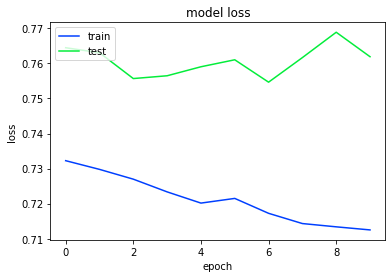

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('present_segment.png')
plt.show()

In [58]:
convNN.save_weights('thisisabetterone.h5')

In [32]:
pred_op=convNN.predict(np.array(Xtest))

Text(0.5, 0, 'Phase')

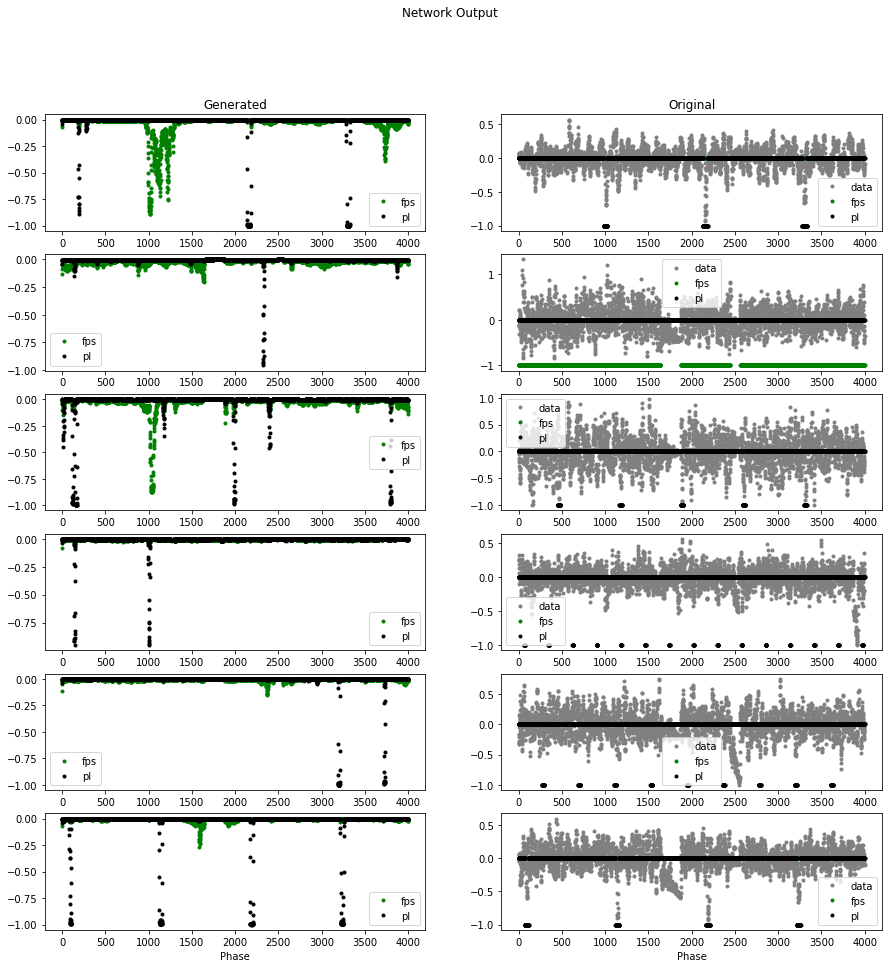

In [34]:

from sklearn.metrics import mean_squared_error
#convNN.load_weights('long_hard_battle_eq.h5')

fig,ax=plt.subplots(6,2,figsize=(15,15))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output')
ar=np.random.randint(len(Xtest),size=10)
#ar=[0,1,2,3,8,7]
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,6):
    #ax[i][0].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='data')
    #ax[i][0].plot(-pred_op[ar[i],:,2],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][0].plot(-pred_op[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][0].plot(-pred_op[ar[i],:,0],color='black',ls='None',marker='.',label='pl')

    ax[i][1].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='data')
    #ax[i][1].plot(-Ytest[ar[i],:,1],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][1].plot(-Ytest[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][1].plot(-Ytest[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    
    #ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    ax[i][0].legend('flux')
    #ax[i][0].set_ylim(-1.05,0.1)
    #ax[i][1].set_ylim(-1.05,0.1)
    ax[i][0].legend()
    ax[i][1].legend()
ax[5][0].set_xlabel('Phase')
ax[5][1].set_xlabel('Phase')

#plt.savefig('present_itsamust')


In [35]:
#convNN.save_weights('deeperFCN_transit_rv.h5')
#convNN.save('Model_long_hard_battle_av.h5')
print(pred_op.shape,Ytest.shape)

(2092, 4000, 3) (2092, 4000, 3)


In [36]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(np.around(Ytest[:,:,0:3]), np.around(pred_op[:,:,0:3]))
m.result().numpy()
#print(pred_op[0:10,0:30])
#print(generalized_dice_coeff(Ytest,pred_op))

0.75829923

In [40]:
#orthodox threshold method to generate metric
class_Ytest=[]
class_Ypred=[]
for el in pred_op:
    pl=np.array(el[:,0]>0.50).sum()
    fps=np.array(el[:,1]>0.90).sum()
    if(pl>fps):class_Ypred.append(0)
    else: class_Ypred.append(1)

for el in Ytest:
    pl=np.array(el[:,0]>0.30).sum()
    fps=np.array(el[:,1]>0.30).sum()
    if(pl>fps):class_Ytest.append(0)
    else: class_Ytest.append(1)
    #4800,2
#[print(class_Ypred[i],class_Ytest[i]) for i in range(0,len(class_Ytest))]

cm=confusion_matrix(class_Ytest,class_Ypred)
print(cm/cm.sum())
print((cm[0,0]+cm[1,1])/cm.sum())

[[0.43307839 0.09416826]
 [0.15535373 0.31739962]]
0.7504780114722753


In [41]:
#pixel accuracy ratio
ptest=[np.argmax(el) for el in np.reshape(pred_op,(len(pred_op)*4000,3))]
ppred=[np.argmax(el) for el in np.reshape(Ytest,(len(Ytest)*4000,3))]

cm=confusion_matrix(ptest, ppred)
print(cm/cm.sum())
print((cm[0,0]+cm[1,1]+cm[2,2])/cm.sum())

[[0.00661938 0.0026115  0.00294192]
 [0.00117651 0.06180545 0.03686496]
 [0.03035385 0.11188898 0.74573745]]
0.8141622848948374


0.7463907149084168
(3,) (3,) (3,)


Text(0, 0.5, 'True Positive Rate')

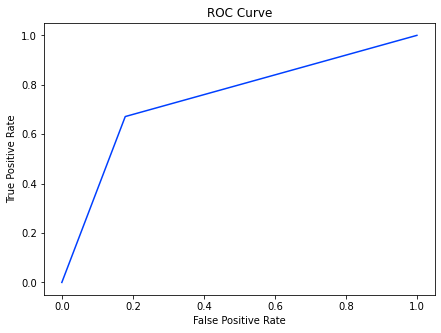

In [42]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

fpr , tpr, thes= roc_curve(class_Ytest,class_Ypred,pos_label=1)
print(auc(fpr,tpr))
print(fpr.shape,tpr.shape,thes.shape)
plt.style.use('seaborn-bright')
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

0.13583859289065003 0.4817272237269208
12 41 25 0
checkalg 0.3110547 0.26639375 0.9240333 0.12836915


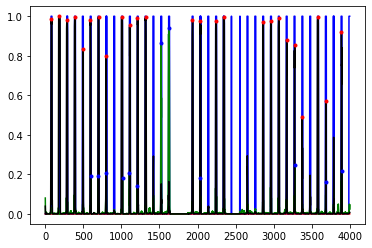

In [43]:
#finding periodicity and all
from scipy.signal import argrelextrema,find_peaks
note=40
x=pred_op[note,:,1]
x2=pred_op[note,:,0]
y=Ytest[note,:,1]
y2=Ytest[note,:,0]
h=(np.median(x)+2*np.std(x))
h2=(np.median(x2)+2*np.std(x2))
print(h,h2)
kernel_size = 22
kernel = np.ones(kernel_size) / kernel_size
#x=np.convolve(x, kernel, mode='same')
#Xtrain = [np.convolve(Xtrain[i], kernel, mode='same') for i in range(IP)]
#Xtest = [np.convolve(Xtest[i], kernel, mode='same') for i in range(TEST)]
peaksf, _ = find_peaks(x, height=h,distance=20)
peaksp, _ = find_peaks(x2, height=h2,distance=20)
peaksft,_ = find_peaks(y, height=0)
peakspt,_ = find_peaks(y2, height=0)
print(len(peaksf),len(peaksft),len(peaksp),len(peakspt))

plwh=np.where(y==1)[0]
fpswh=np.where(y2==1)[0]

print("checkalg",np.mean(x[peaksf]),np.std(x[peaksf]),np.mean(x2[peaksp]),np.std(x2[peaksp]))

plt.plot(y,color='blue')
plt.plot(y2,color='red')
plt.plot(x,color='green')
plt.plot(x2,color='black')

plt.plot(peaksf,x[peaksf],color="blue",marker=".",ls='None')
#plt.plot(peaksft,y[peaksft],color="blue",marker=".",ls='None')
plt.plot(peaksp,x2[peaksp],color="red",marker=".",ls='None')
#plt.plot(peakspt,y2[peakspt],color="red",marker=".",ls='None')


#plt.xlim(0,2000)
plt.show()

In [44]:
#new code to get periodicity... idk if its gonna be worthwile but lets see
#get test data
class_Ytest=[]
for el in Ytest:
    xpl=el[:,0]
    xfps=el[:,1]
    plp, _ = find_peaks(xpl, height=0)
    pfps, _ = find_peaks(xfps, height=0)
    class_Ytest.append([len(plp),len(pfps)])

class_Ypred=[]
pred_conf=[]
for el in pred_op:
    pl = el[:,0]
    hpl = np.median(pl)+0.1*np.std(pl)
    fps = el[:,1]
    hfps = np.median(fps)+0.1*np.std(fps)
    plp, _ = find_peaks(pl, height=hpl,distance=5)
    fpsp, _ = find_peaks(fps, height=hfps,distance=5) 
    if(len(plp>0)): 
        val1=np.mean(pl[plp])
        std1=np.std(pl[plp])
    else: 
        val1=0
        std1=0
    if(len(fpsp)>0): 
        val2=np.mean(fps[fpsp])
        std2=np.std(fps[fpsp])
    else: 
        val2=0
        std2=0
          
    class_Ypred.append([val1,val2])
    pred_conf.append([std1,std2])
    

print(np.asarray(class_Ypred).shape,np.asarray(class_Ytest).shape)

(2092, 2) (2092, 2)


In [45]:
n_pred=[]
n_test=[]
good_preds=0
for i in range(len(class_Ypred)):
    #planet
    ind=np.argmax(class_Ypred[i])
    if(class_Ypred[i][ind]-1*pred_conf[i][ind] > class_Ypred[i][1-ind] + 1*pred_conf[i][1-ind]): good_preds+=1
    #else: continue
    n_pred.append(ind)
    if(class_Ytest[i][0]>0 and class_Ytest[i][1]>0): n_test.append(np.argmax(class_Ypred[i]))
    elif(class_Ytest[i][0]>0): n_test.append(0)
    else:  n_test.append(1)

cm=confusion_matrix(np.asarray(n_test),np.asarray(n_pred))
print(good_preds)
print(cm/cm.sum())

856
[[0.41443595 0.11567878]
 [0.13527725 0.33460803]]


Text(0.5, 0, 'Time')

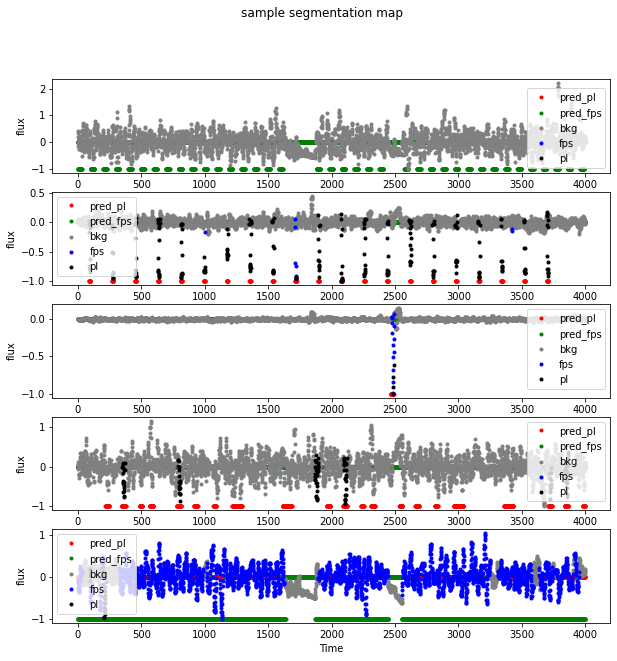

In [46]:
#make some chummy plots
#ar=[0,5,6,11,13]
ar=np.random.randint(0,len(Xtest),size=5)
#ar=[194,201,202,203,206]
fig,ax=plt.subplots(5,1,figsize=(10,10))
plt.style.use('seaborn-bright')
plt.suptitle('sample segmentation map')
ind=np.arange(0,4000)

for i in range(0,5):
    plotlab=pred_op[ar[i],:,:]
    counts=np.asarray([np.argmax([el[0],el[1],el[2]/2]) for el in plotlab])
    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    #predpl = np.where(Ytest[ar[i],:,0]==1)[0]
    bkg=np.where(counts==2)[0]
    #ax[i].plot(ind[predpl],-Ytest[ar[i],predpl,0],marker='.',ls='None',color="red",label='pred')
    ax[i].plot(-Ytest[ar[i],:,0],marker='.',ls='None',color="red",label='pred_pl')
    ax[i].plot(-Ytest[ar[i],:,1],marker='.',ls='None',color="green",label='pred_fps')
    ax[i].plot(ind[bkg],Xtest[ar[i],bkg],color='gray',marker='.',ls='None',label='bkg')
    ax[i].plot(ind[fps],Xtest[ar[i],fps],color='blue',marker='.',ls='None',label='fps') 
    ax[i].plot(ind[pl],Xtest[ar[i],pl],color='black',marker='.',ls='None',label='pl')
    ax[i].legend()
    ax[i].set_ylabel('flux')
    #ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    
    #ax[i][0].legend()
ax[4].set_xlabel('Time')
#plt.savefig('instseg4.png')


In [47]:
#another
class_Ypred=[]
class_Ytest=[]
for i in range(0,len(pred_op)):
    plotlab=pred_op[i,:,:]
    counts=np.asarray([np.argmax([el[0],el[1]]) for el in plotlab])
    pl=(counts==0).sum()
    fps=(counts==1).sum()
    #bkg=(counts==2).sum()
    if(pl==0 and fps ==0): continue
    if(pl>fps): class_Ypred.append(0)
    else: class_Ypred.append(1)

    tpl=Ytest[i,:,0].sum()
    tfps=Ytest[i,:,1].sum()
    if(tpl>tfps): class_Ytest.append(0)
    else: class_Ytest.append(1)

cm=confusion_matrix(np.asarray(class_Ytest),np.asarray(class_Ypred))
print(cm)


[[   0 1103]
 [   0  989]]


In [48]:
#evaluate transits by grouping:
#convNN.load_weights('thisisagoodone.h5')
pred_op=convNN.predict(np.array(Xtest))

maxarr_pred = [[ np.argmax(np.asarray([x[0],x[1],x[2]/2])) for x in el] for el in pred_op]
maxarr_predpl  =[[x==0 for x in el] for el in maxarr_pred]
maxarr_predfps  =[[x==1 for x in el] for el in maxarr_pred]
#maxarr_testpl = [[np.argmax([el[2],el[0]]) for x in el] for el in Xtest]
#maxarr_predfps = [[np.argmax(np.asarray([x[2],x[1]])) for x in el] for el in pred_op]
#maxarr_testfps = [[np.argmax([el[2],el[1]]) for x in el] for el in Xtest]

In [49]:
print(np.asarray(maxarr_predpl).shape)

(2092, 4000)


In [50]:
from scipy.signal import argrelextrema,find_peaks

corrects=np.asarray([[0,0],[0,0]])
for i in range(0,len(pred_op)):
    plp, _ = find_peaks(maxarr_predpl[i], height=0.3,distance=20) 
    for m in plp:
        if(Ytest[i,m,0]>0.5): corrects[0,0]+=1
        elif(Ytest[i,m,1]>0.5): corrects[1,0]+=1
        #if(Ytrain[i,m,2]>0.5): corrects[2,0]+=1
        #else: corrects[2,0]+=1
    fpsp, _ = find_peaks(maxarr_predfps[i], height=0.3,distance=20)
    for m in fpsp:
        if(Ytest[i,m,1]>0.1): corrects[1,1]+=1
        elif(Ytest[i,m,0]>0.1): corrects[0,1]+=1
        #if(Ytrain[i,m,2]>0.1): corrects[0,2]+=1
        #else: corrects[0,2]+=1

print(corrects/corrects.sum())
print((corrects[0,0]+corrects[1,1])/corrects.sum())

[[0.18659534 0.03908118]
 [0.08892385 0.68539962]]
0.8719949653870359


In [51]:
from astropy.io import ascii
from astropy.table import Table
TestID2 = [TestID[i].numpy() for i in range(0,len(TestID))]
TestID2 = [str(TestID2[i])[2:11] for i in range(0,len(TestID2))]
print(TestID2[2:10])
Ytest = np.asarray(Ytest, dtype = 'float32')

for i in range(0,len(Xtest)):
    data = Table()
    data['RAW'] = Xtest[i]
    data['PL_MAP'] = Ytest[i,:,0]
    data['FPS_MAP'] = Ytest[i,:,1]
    data['BKG_MAP'] = Ytest[i,:,2]
    data['PRED_PL_MAP'] = pred_op[i,:,0]
    data['PRED_FPS_MAP'] = pred_op[i,:,1]
    data['PRED_BKG_MAP'] = pred_op[i,:,2]
    ascii.write(data, '../../processed_directories/sem_seg_op/'+str(np.asarray(TestID2)[i]), overwrite=True)
    

['009899181', '009774400', '011600889', '002438513', '009425139', '007024511', '005653163', '011518142']


In [52]:
print(np.asarray(TestID).shape, Xtest.shape)

(2092,) (2092, 4000)


In [90]:
#here we are setting up an expanded semantic segmentation problem
import os
from scipy.signal import find_peaks

def peak_cm(pred_op, true_op):
  maxarr_pred = np.argmax(pred_op,axis=-1)
  maxarr_predpl  = np.asarray(maxarr_pred==0,dtype='int')
  maxarr_predfps  = np.asarray(maxarr_pred==1, dtype='int')

  corrects=np.asarray([[0,0],[0,0]])
  peak_pl=[]
  peak_fps=[]
  for i in range(0,len(pred_op)):
      plp, _ = find_peaks(maxarr_predpl[i], height=0.3,distance=20) 
      peak_pl.append(plp)
      for m in plp:
          if(true_op[i,m,0]>0.5): corrects[0,0]+=1
          #elif(true_op[i,m,1]>0.5): corrects[1,0]+=1
          else: corrects[1,0]+=1
      fpsp, _ = find_peaks(maxarr_predfps[i], height=0.3,distance=20)
      peak_fps.append(fpsp)
      for m in fpsp:
          if(true_op[i,m,1]>0.1): corrects[1,1]+=1
          else: corrects[0,1]+=1

  #print(corrects/corrects.sum())
  #print((corrects[0,0]+corrects[1,1])/corrects.sum())
  print(corrects[0,0],corrects[1,1])
  corrects = corrects.reshape(-1)
  return(corrects,peak_pl,peak_fps)

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _floats_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

def _parse_tfr_element_next(element):
  desc = {
        'input':tf.io.FixedLenFeature([], tf.string),
        'map':tf.io.FixedLenFeature([], tf.string),  
    }
  example_message = tf.io.parse_single_example(element, desc)

  #return(example_message['counts'])
  binp = example_message['input'] # get byte 
  bmap = example_message['map'] # get byte string
  inp = tf.io.parse_tensor(binp, out_type=tf.double) # restore 2D array from byte string
  map = tf.io.parse_tensor(bmap, out_type=tf.double)
  return (inp,map)

#lets write it out to the same file... thats better 
convNN.load_weights('thisisabetterone.h5')
test_dir = os.listdir('../../processed_directories/expand_test/')
for el in test_dir :
  tfr_testdata = tf.data.TFRecordDataset(['../../processed_directories/expand_test/'+el]) 
  testdata = tfr_testdata.map(_parse_tfr_element_next)
  Xtest = []
  Ytest = []
  for instance in testdata:
      Xtest.append(instance[0])
      Ytest.append(instance[1])
  
  Xtest = np.asarray(Xtest, dtype='float32')
  Ytest = np.asarray(Ytest, dtype='float32')
  Ytest = np.reshape(Ytest,(len(Xtest),4000,3))

  kernel_size = 8
  kernel = np.ones(kernel_size) / kernel_size
  medarr=[np.median(row) for row in Xtest]
  stdarr=[np.std(row) for row in Xtest]
  Xtest = np.array([np.convolve(Xtest[i], kernel, mode='same') for i in range(len(Xtest))])
  Xtest=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])
   
  Ypred = convNN.predict(Xtest)

  #pixel accuracy ratio
  ptest=[np.argmax(el) for el in np.reshape(Ypred,(len(Ypred)*4000,3))]
  ppred=[np.argmax(el) for el in np.reshape(Ytest,(len(Ytest)*4000,3))]

  cm=confusion_matrix(ptest, ppred)
  pixacc = (cm[0,0]+cm[1,1])/cm.sum()
  groupacc, peak_pl, peak_fps = peak_cm(Ypred, Ytest) 
  

  print(el, pixacc, (groupacc[0]+groupacc[3])/groupacc.sum())

  np.reshape(Ytest,(len(Ytest),12000))
  np.reshape(Ypred,(len(Ypred),12000))

  writer = tf.io.TFRecordWriter('../../processed_directories/expand_test_result/'+el) #create a writer that'll store our data to disk

  for i in range(0,len(Xtest)):
    desc = {
      'input':_bytes_feature(serialize_array(np.asarray(Xtest[i],dtype='float32'))), #f32
      'true_map': _bytes_feature(serialize_array(np.asarray(Ytest[i],dtype='float32'))), #f32
      'pred_map':_bytes_feature(serialize_array(np.asarray(Ypred[i],dtype='float32'))), 
      # 'pixel_acc':_floats_feature(pixacc),
      'scale_median':_floats_feature(medarr[i]),
      'scale_std':_floats_feature(stdarr[i]),
      'pl_peaks':_bytes_feature(serialize_array(np.asarray(peak_pl[i],dtype='int16'))),
      'fps_peaks':_bytes_feature(serialize_array(np.asarray(peak_fps[i],dtype='int16'))),
    }
    out = tf.train.Example(features=tf.train.Features(feature=desc))
    writer.write(out.SerializeToString())

  writer.close()


0 111
001026133 0.14277083333333335 0.4955357142857143
0 67
001160891 0.79225 0.7701149425287356
0 202
001162150 0.23520833333333332 0.7890625
0 137
001162345 0.8686458333333333 0.9072847682119205
0 119
001296721 0.13516666666666666 0.4817813765182186
0 52
001430590 0.08797916666666666 0.6753246753246753
0 44
001433899 0.0210625 0.43137254901960786
0 90
001576144 0.0915625 0.2803738317757009
0 185
001577039 0.4830625 0.8809523809523809
0 1
001717528 0.001125 0.047619047619047616
0 0
001718958 0.00022916666666666666 0.0
0 40
001719308 0.043020833333333335 0.17467248908296942
12 0
001725016 0.0049722222222222225 0.42857142857142855
16 0
001872821 0.005479166666666667 0.5
0 170
001872948 0.29970833333333335 0.5246913580246914
0 12
002014991 0.012645833333333334 0.06451612903225806
0 218
002018261 0.23358333333333334 0.5165876777251185
3 0
002019477 0.0013541666666666667 0.017045454545454544
6 0
002141783 0.00709375 0.2
3 0
002161949 0.0011041666666666667 0.1875
0 177
002164165 0.590458333

In [88]:
#analyse the result
#convNN.load_weights('thisisabetterone.h5')
def _parse_tfr_element_nexter(element):
  desc = {
        'input':tf.io.FixedLenFeature([], tf.string),
        'true_map':tf.io.FixedLenFeature([], tf.string),  
        'pred_map':tf.io.FixedLenFeature([], tf.string),  
        'pixel_acc':tf.io.FixedLenFeature([], dtype=tf.float32),
        'pl_peaks':tf.io.FixedLenFeature([], tf.string),   
        'fps_peaks':tf.io.FixedLenFeature([], tf.string),  
    }
  example_message = tf.io.parse_single_example(element, desc)

  #return(example_message['counts'])
  binp = example_message['input'] # get byte 
  bmap = example_message['true_map'] # get byte string
  bpmap = example_message['pred_map'] # get byte string
  bacc = example_message['pixel_acc'] # get byte string
  plp = example_message['pl_peaks'] # get byte string
  fpsp = example_message['fps_peaks'] # get byte string
  inp = tf.io.parse_tensor(binp, out_type=tf.float32) # restore 2D array from byte string
  map = tf.io.parse_tensor(bmap, out_type=tf.float32)
  pmap = tf.io.parse_tensor(bpmap, out_type=tf.float32)
  plp = tf.io.parse_tensor(plp, out_type=tf.int16)
  fpsp = tf.io.parse_tensor(fpsp, out_type=tf.int16)
  return (inp,map, pmap, bacc, plp, fpsp)

test_dir = os.listdir('../../processed_directories/expand_test_result/')

acc = []
for el in test_dir:
  tfr_testdata = tf.data.TFRecordDataset(['../../processed_directories/expand_test_result/'+el])
  testdata = tfr_testdata.map(_parse_tfr_element_nexter)
  i=0
  for instance in testdata:
      acc.append(instance[3])
      i+=1
      if(i==1): break
'''
tfr_testdata = tf.data.TFRecordDataset(['../../processed_directories/expand_test_result/'+test_dir[19]]) 
testdata = tfr_testdata.map(_parse_tfr_element_nexter)
Xtest = []
Ytest = []
Ypred = []
acc = []
plp=[]
fpsp=[]
for instance in testdata:
    Xtest.append(instance[0])
    Ytest.append(np.asarray(instance[1]).reshape(4000,3))
    Ypred.append(np.asarray(instance[2]).reshape(4000,3))
    acc.append(instance[3])
    plp.append(instance[4])
    fpsp.append(instance[5])

Ypred = np.asarray(Ypred)
Ytest = np.asarray(Ytest)
print(acc[0], plp[0])

#print(Ypred, Ytest)
fig, ax = plt.subplots(5,1,figsize = (15,10))
for i in range(0,5):
  m = min(Xtest[i])
  ax[i].plot(Ypred[i,:,0],color='red')
  ax[i].plot(Ypred[i,:,1],color='black')
  ax[i].plot(Xtest[i],color='gray')
  ax[i].plot(Ytest[i,:,0]*m,color='blue')
  ax[i].plot(Ytest[i,:,1]*m,color='green')
  ax[i].scatter(plp[i],np.ones(len(plp[i])))
  
  #ax[i].set_ylim(-0.05,0.005)
  ax[i].plot(Ypred[i,:,2]*m, color='black')


plt.show()'''

"\ntfr_testdata = tf.data.TFRecordDataset(['../../processed_directories/expand_test_result/'+test_dir[19]]) \ntestdata = tfr_testdata.map(_parse_tfr_element_nexter)\nXtest = []\nYtest = []\nYpred = []\nacc = []\nplp=[]\nfpsp=[]\nfor instance in testdata:\n    Xtest.append(instance[0])\n    Ytest.append(np.asarray(instance[1]).reshape(4000,3))\n    Ypred.append(np.asarray(instance[2]).reshape(4000,3))\n    acc.append(instance[3])\n    plp.append(instance[4])\n    fpsp.append(instance[5])\n\nYpred = np.asarray(Ypred)\nYtest = np.asarray(Ytest)\nprint(acc[0], plp[0])\n\n#print(Ypred, Ytest)\nfig, ax = plt.subplots(5,1,figsize = (15,10))\nfor i in range(0,5):\n  m = min(Xtest[i])\n  ax[i].plot(Ypred[i,:,0],color='red')\n  ax[i].plot(Ypred[i,:,1],color='black')\n  ax[i].plot(Xtest[i],color='gray')\n  ax[i].plot(Ytest[i,:,0]*m,color='blue')\n  ax[i].plot(Ytest[i,:,1]*m,color='green')\n  ax[i].scatter(plp[i],np.ones(len(plp[i])))\n  \n  #ax[i].set_ylim(-0.05,0.005)\n  ax[i].plot(Ypred[i,:,2]*

0.15067598


<function matplotlib.pyplot.show(close=None, block=None)>

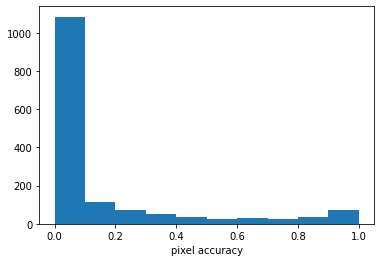

In [89]:
#plt.hist(acc)
#plt.show
acc2 = [el.numpy()  for el in acc]
plt.hist(acc2)
print(np.mean(np.asarray(acc2)))
plt.xlabel('pixel accuracy')
plt.savefig('testacc.png')
plt.show